<a href="https://colab.research.google.com/github/yperdana/Waste-Image-Classification/blob/master/Garbage_Classification_Using_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Bangkit Program
Waste Classification using ResNet

In [8]:
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential

Building The Model

In [9]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [11]:
num_class = 6

model = Sequential([ResNet50(include_top=False,
                             weights='imagenet',
                             pooling='avg'),
                    Dense(num_class, activation='softmax')])

model.layers[0].trainable = False


In [10]:
from tensorflow.keras.optimizers import SGD


In [12]:
lr = 0.01
momentum = 0.001
opt = SGD(learning_rate=lr, momentum=momentum)

model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


Load Dataset

In [13]:
from keras.preprocessing.image import ImageDataGenerator

data_path = "/content/drive/My Drive/Bangk!t/Training Data/Final Project"

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

img_shape = 224
train_gen = data_generator.flow_from_directory(data_path + '/train',
                                               target_size=(img_shape, img_shape),
                                               batch_size=64,
                                               class_mode='categorical')

val_gen = data_generator.flow_from_directory(data_path + '/valid',
                                             target_size=(img_shape, img_shape),
                                             batch_size=1,
                                             class_mode='categorical',
                                             shuffle=False)

Found 2291 images belonging to 6 classes.
Found 211 images belonging to 6 classes.


Train the Model


In [16]:
from tensorflow.keras.callbacks import ModelCheckpoint

n_epoch = 30

model_name = 'resnet50_batch64_sgd01m001'
checkpoint = ModelCheckpoint('./' +  model_name + '.h5',
                             monitor='val_loss',
                             save_best_only=True,
                             verbose=1)

history = model.fit_generator(train_gen,
                              steps_per_epoch=train_gen.samples/train_gen.batch_size,
                              validation_data=val_gen,
                              validation_steps=val_gen.samples/val_gen.batch_size,
                              epochs=n_epoch,
                              callbacks=[checkpoint])

Epoch 1/30
36/35 [==============================] - ETA: -1s - loss: 0.1323 - accuracy: 0.9712
Epoch 00001: val_loss improved from inf to 0.21681, saving model to ./resnet50_batch64_sgd01m001.h5
36/35 [==============================] - 350s 10s/step - loss: 0.1323 - accuracy: 0.9712 - val_loss: 0.2168 - val_accuracy: 0.9242
Epoch 2/30
36/35 [==============================] - ETA: -1s - loss: 0.1294 - accuracy: 0.9681
Epoch 00002: val_loss did not improve from 0.21681
36/35 [==============================] - 350s 10s/step - loss: 0.1294 - accuracy: 0.9681 - val_loss: 0.2206 - val_accuracy: 0.9194
Epoch 3/30
36/35 [==============================] - ETA: -1s - loss: 0.1263 - accuracy: 0.9742
Epoch 00003: val_loss improved from 0.21681 to 0.21444, saving model to ./resnet50_batch64_sgd01m001.h5
36/35 [==============================] - 351s 10s/step - loss: 0.1263 - accuracy: 0.9742 - val_loss: 0.2144 - val_accuracy: 0.9289
Epoch 4/30
36/35 [==============================] - ETA: -1s - loss

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


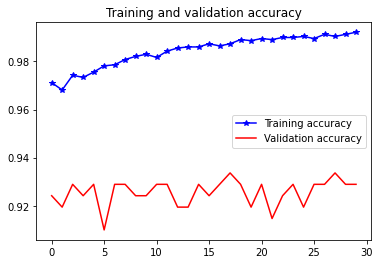

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
acc = history.history['accuracy']
loss = history.history['loss']

plt.plot(range(n_epoch), acc, 'b*-', label = 'Training accuracy')
plt.plot(range(n_epoch), val_acc, 'r', label = 'Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

Test Model

In [19]:
data_path = "/content/drive/My Drive/Bangk!t/Training Data/Final Project"

data_generator = ImageDataGenerator(preprocessing_function=preprocess_input)

test_gen = data_generator.flow_from_directory(data_path + '/test',
                                              target_size=(img_shape, img_shape),
                                              batch_size=1,
                                              class_mode='categorical',
                                              shuffle=False)

Found 55 images belonging to 6 classes.


In [20]:
from tensorflow.keras.models import load_model
import numpy as np

eval_model = load_model('./' + model_name + '.h5')
eval_model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 2048)              23587712  
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 12294     
Total params: 23,600,006
Trainable params: 12,294
Non-trainable params: 23,587,712
_________________________________________________________________


Instructions for updating:
Please use Model.predict, which supports generators.
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        10
           1       0.83      1.00      0.91        10
           2       0.82      0.90      0.86        10
           3       0.80      0.80      0.80        10
           4       0.78      0.70      0.74        10
           5       1.00      0.60      0.75         5

    accuracy                           0.85        55
   macro avg       0.87      0.83      0.84        55
weighted avg       0.86      0.85      0.85        55



Text(0.5, 1.0, 'Confusion matrix of model')

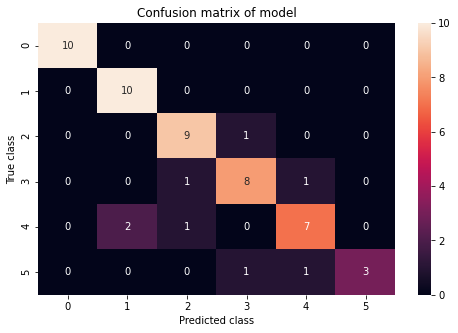

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = eval_model.predict_generator(test_gen)
y_pred = np.argmax(y_pred, axis=1)

print(classification_report(test_gen.classes, y_pred))

cf_matrix = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize=(8,5))
heatmap = sns.heatmap(cf_matrix, annot=True, fmt='d', color='blue')
plt.xlabel('Predicted class')
plt.ylabel('True class')
plt.title('Confusion matrix of model')
